[<img align="right" width="400" height="100" src="https://www.tu-braunschweig.de/typo3conf/ext/tu_braunschweig/Resources/Public/Images/Logos/tu_braunschweig_logo.svg">](https://www.tu-braunschweig.de/en/) 

[Mehdi Maboudi](https://www.tu-braunschweig.de/en/igp/staff/mehdi-maboudi) \([m.maboudi@tu-bs.de](m.maboudi@tu-bs.de)) and [Pedro Diaz](https://www.tu-braunschweig.de/en/igp/staff/pedro-diaz) (p.diaz@tu-bs.de)

[Technical University of Braunschweig](https://www.tu-braunschweig.de/en/)  
[Institute of Geodesy and Photogrammetry](https://www.tu-braunschweig.de/igp)  


**Image classification using MLP**  

# Deep Learning Entry Task with randomness fixed
<!--<badge>--><a href="https://colab.research.google.com/github/Deep-Learning-IGP-TUBS-SoSe2022/2022-Group06/blob/main/Assignments/00-EntryTask_MLP_FashionMNIST/hbusul/Deep_Learning_SoSe2022_EntryTask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--</badge>-->

## 1. Import all necessary packages

In [1]:
import itertools

import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import torchvision.transforms as T

from PIL import Image
from torch.utils.data import DataLoader, random_split
from torch.optim import Adam

# let's try to fix randomness
torch.backends.cudnn.enabled = False
torch.backends.cudnn.deterministic = True

/home/burak/anaconda3/envs/ml/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Load the [Fashion MNIST dataset](https://github.com/zalandoresearch/fashion-mnist]) for image classification and show some samples 
It is also available in [PyTorch datasets](https://pytorch.org/vision/stable/datasets.html) and [TensorFlow datasets](https://www.tensorflow.org/datasets)

### 2.1 Loading the dataset

In [2]:
train_set = torchvision.datasets.FashionMNIST(
    "./fashion_mnist",
    download=True,
    train=True,
    transform=T.ToTensor()
)


test_set = torchvision.datasets.FashionMNIST(
    "./fashion_mnist",
    download=True,
    train=False,
    transform=T.ToTensor()
)

train_set, valid_set = random_split(train_set, [58000, 2000], generator=torch.Generator().manual_seed(42))
print("Train set size", len(train_set))
print("Valid set size", len(valid_set))
print("Test set size", len(test_set))

Train set size 58000
Valid set size 2000
Test set size 10000


### 2.2 Visualizing the dataset

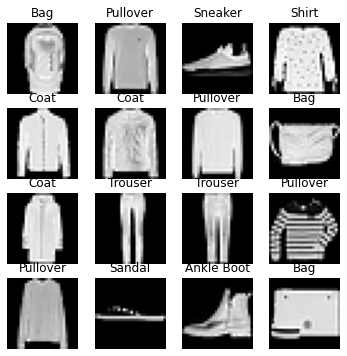

In [3]:
labels_map = ["T-Shirt", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"]
figure = plt.figure(figsize=(6, 6))
indices = [
    46820, 45522, 18801, 48851, 48591,
    27296, 29424, 3751, 33476, 56649,
    20096, 8640, 36985, 14298, 22290, 28469
] # :D
for i in range(1, 17): # 17 = 4 col * 4 row + 1
    index = indices[i - 1]
    img, label = train_set[index]
    figure.add_subplot(4, 4, i) # 4 row 4 column
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## 3. Create a **Multi Layer Perceptron (MLP)** for image classification.
Feel free to use any configuration and framework for its implementation (Keras, Tensorflow, Pytorch, etc.)

In [5]:
class MLPModel(torch.nn.Module):
    def __init__(self, input_size=28*28):
        super(MLPModel, self).__init__()
        self.linear1 = torch.nn.Linear(input_size, 128)
        self.linear2 = torch.nn.Linear(128, 128)
        self.linear3 = torch.nn.Linear(128, 10)
        self.relu = torch.nn.ReLU()
        self.softmax = torch.nn.Softmax(dim=1)
        
    def forward(self, x):
        x = x.reshape(x.shape[0], -1)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        x = self.softmax(x)
        return x

## 4. Train the model

In [6]:
# let's try to fix randomness
torch.manual_seed(123)
torch.cuda.manual_seed(123)

loss = torch.nn.CrossEntropyLoss()
model = MLPModel()

optimizer = Adam(model.parameters(), lr=.001) # I also tried .01 and 0.0001
# we want to train in batches
train_dataloader = DataLoader(train_set, batch_size=128, shuffle=True)
valid_dataloader = DataLoader(valid_set, batch_size=512, shuffle=False) # no need to shuffle since we only test on it
loss_per_epoch_tmp = []
accuracy_per_epoch_tmp = []
for epoch in range(10):
    model.train()
    #I tried to overfit the first batch to see if model was ok
    #first_batch = next(iter(train_dataloader))
    #for batch_idx, (images, labels) in enumerate([first_batch] * 50):
    sum_loss = 0.0
    for images, labels in train_dataloader:
        output = model(images)
        loss_batch = loss(output, labels)
        sum_loss += loss_batch.item() * images.shape[0]
        optimizer.zero_grad()
        loss_batch.backward()
        optimizer.step()
    loss_per_epoch_tmp.append(sum_loss / len(train_set))
    # save weights    
    # torch.save(model.state_dict(), f"./model_states/ep_{epoch}.pth")
    model.eval()
    accuracy = []
    #for batch_idx, (images, labels) in enumerate([first_batch]):
    for images, labels in valid_dataloader:
        output = model(images)
        output = torch.argmax(output, 1)
        accuracy.append(output == labels)
    accuracy = torch.cat(accuracy).double().mean()
    accuracy_per_epoch_tmp.append(accuracy)
    print(f"Epoch {epoch}, Avg loss {loss_per_epoch_tmp[-1]}, Validation set accuracy {accuracy}")
loss_per_epoch = loss_per_epoch_tmp
accuracy_per_epoch = accuracy_per_epoch_tmp

Epoch 0, Avg loss 1.727589510654581, Validation set accuracy 0.81
Epoch 1, Avg loss 1.630965333774172, Validation set accuracy 0.835
Epoch 2, Avg loss 1.616591592953123, Validation set accuracy 0.832
Epoch 3, Avg loss 1.6089180501740554, Validation set accuracy 0.837
Epoch 4, Avg loss 1.6030959619653635, Validation set accuracy 0.8525
Epoch 5, Avg loss 1.5989304000262556, Validation set accuracy 0.8585
Epoch 6, Avg loss 1.5983039103540881, Validation set accuracy 0.8445
Epoch 7, Avg loss 1.5897518673929676, Validation set accuracy 0.8525
Epoch 8, Avg loss 1.5891601454964999, Validation set accuracy 0.8485
Epoch 9, Avg loss 1.5856854871881418, Validation set accuracy 0.855


## 5. Plots
Plot the evolution of the Loss function and Accuracy values over the epochs during training.

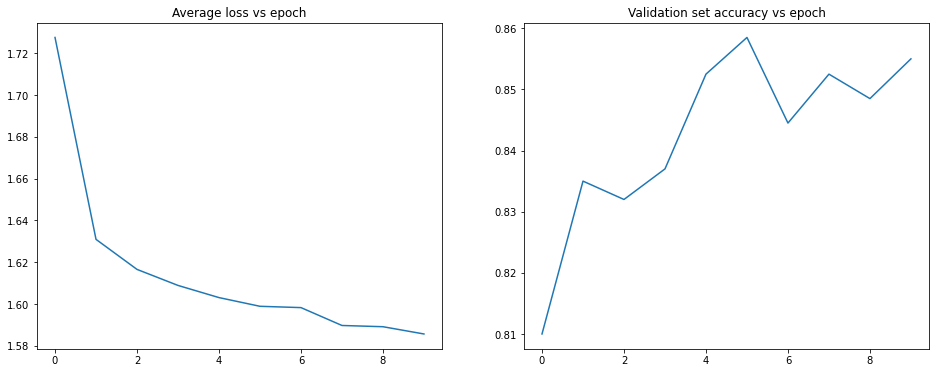

In [7]:
figure = plt.figure(figsize=(16, 6))
figure.add_subplot(1, 2, 1)
plt.title("Average loss vs epoch")
plt.plot(np.array(loss_per_epoch))
figure.add_subplot(1, 2, 2)
plt.title("Validation set accuracy vs epoch")
plt.plot(np.array(accuracy_per_epoch))
plt.show()

## 6. Run inference
Run inference in the test set and compute the metrics for testing.

Test set accuracy 0.8557


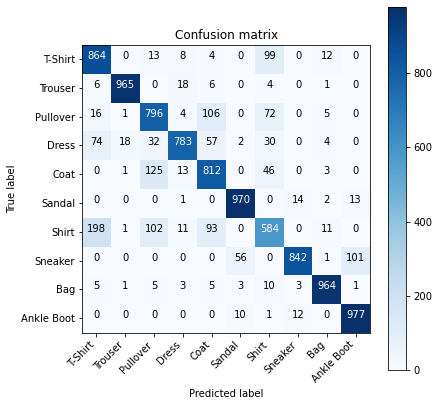

In [8]:
# COPY PASTED FROM https://stackoverflow.com/questions/54772689/python-confusion-matrix-matplotlib-automatic-figure-size-based-on-the-number-of
# DISCLAIMER: I DID NOT IMPLEMENT THE FOLLOWING FUNCTION
def plot_confusion_matrix(confusion_matrix, classes, normalize=False, cmap=cm.Blues, png_output=None, show=True):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        confusion_matrix = cm.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
        title='Normalized confusion matrix'
    else:
        title='Confusion matrix'

    # Calculate chart area size
    leftmargin = 0.5 # inches
    rightmargin = 0.5 # inches
    categorysize = 0.5 # inches
    figwidth = leftmargin + rightmargin + (len(classes) * categorysize)           

    f = plt.figure(figsize=(figwidth, figwidth))

    # Create an axes instance and ajust the subplot size
    ax = f.add_subplot(111)
    ax.set_aspect(1)
    f.subplots_adjust(left=leftmargin/figwidth, right=1-rightmargin/figwidth, top=0.94, bottom=0.1)

    res = ax.imshow(confusion_matrix, interpolation='nearest', cmap=cmap)

    plt.title(title)
    plt.colorbar(res)
    ax.set_xticks(range(len(classes)))
    ax.set_yticks(range(len(classes)))
    ax.set_xticklabels(classes, rotation=45, ha='right')
    ax.set_yticklabels(classes)

    fmt = '.2f' if normalize else 'd'
    thresh = confusion_matrix.max() / 2.
    for i, j in itertools.product(range(confusion_matrix.shape[0]), range(confusion_matrix.shape[1])):
        ax.text(j, i, format(confusion_matrix[i, j], fmt),
                horizontalalignment="center",
                color="white" if confusion_matrix[i, j] > thresh else "black")

    # plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    if png_output is not None:
        os.makedirs(png_output, exist_ok=True)
        f.savefig(os.path.join(png_output,'confusion_matrix.png'), bbox_inches='tight')

    if show:
        plt.show()
        plt.close(f)
    else:
        plt.close(f)


confusion = np.zeros((10, 10), dtype=int)

test_dataloader = DataLoader(test_set, batch_size=512, shuffle=False) # no need to shuffle since we only test on it
test_accuracy = []
for images, labels in test_dataloader:
    output = model(images)
    output = torch.argmax(output, 1)
    for i in range(len(output)):
        confusion[labels[i], output[i]] += 1
    test_accuracy.append(output == labels)
test_accuracy = torch.cat(test_accuracy).double().mean()
print(f"Test set accuracy {test_accuracy}")
labels_map = ["T-Shirt", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"]
plot_confusion_matrix(confusion, labels_map)

## 7. Test samples
Show some samples from the test set: image, reference class and predicted class.

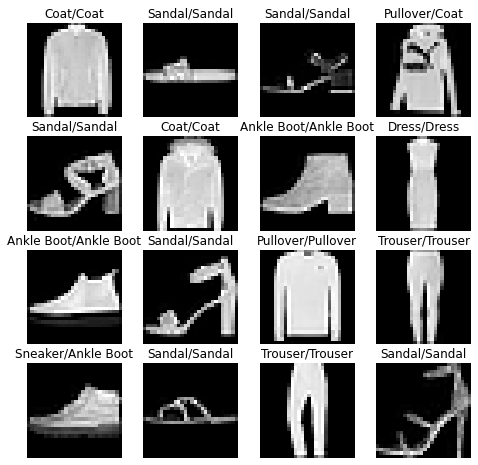

In [13]:
model.eval()
# titles are original label / predicted label
labels_map = ["T-Shirt", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"]
figure = plt.figure(figsize=(8, 8))
indices = [7592, 5870, 9467, 1322, 8941, 5686, 7524, 1724, 7983, 1289, 7034, 1914, 6268, 4770, 1550, 5728]
for i in range(1, 17): # 17 = 4 col * 4 row + 1
    index = indices[i - 1]
    img, label = test_set[index]
    guess = model(img.unsqueeze(0)).argmax()
    figure.add_subplot(4, 4, i) # 4 row 4 column
    plt.title(f"{labels_map[label]}/{labels_map[guess.item()]}" )
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")

plt.show()

## 8. Testing with rotation
Choose one image from the test set, apply a rotation (e.g. 30°, 45°, 60°).

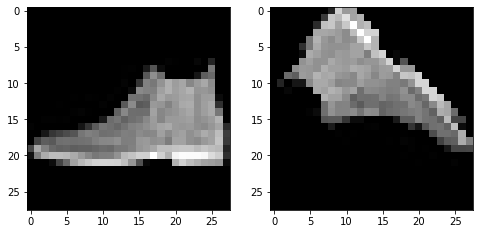

In [14]:
image, label = test_set[0]
image_rotated = T.functional.rotate(image, 135)

figure = plt.figure(figsize=(8, 8))
figure.add_subplot(1, 2, 1)
plt.imshow(image.squeeze(), cmap="gray")

figure.add_subplot(1, 2, 2)
plt.imshow(image_rotated.squeeze(), cmap="gray")

plt.show()

## 9. Comparison
Compare the predicted classes before and after the rotation. Is there any change? If yes, what would be the reason for it?

In [15]:
new_label = model(image_rotated.unsqueeze(0)).argmax()

print("Old label:", labels_map[label],", new label:", labels_map[new_label.item()])

# Yes, there is a change because most probably in our training set the 'ankle boot' images were from
# a particular angle, so when I rotate this image 135 degrees, the filters for a shirt matches this
# more than the filters for the ankle boot.



Old label: Ankle Boot , new label: Shirt


## 10. Testing with new image
Test the model with another image (from internet or take a photo with your phone). Do not forget to convert the image to the Fashion MNIST format: grayscale, $28\times 28$. Comment the results.

Original label: T-shirt, guessed label Bag


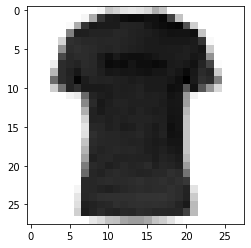

In [16]:
new_image = Image.open('./tshirt.png')
new_image = T.functional.pil_to_tensor(new_image)
grayscale = T.Grayscale(1)
new_image = grayscale(new_image)
new_image = new_image / 255
plt.imshow(new_image.squeeze(), cmap="gray")
new_label = model(new_image.unsqueeze(0)).argmax().item()
print(f"Original label: T-shirt, guessed label {labels_map[new_label]}")

## 11. How could we improve the trained model?

We could continue training until the validation set error accuracy stops increasing, we could use a bigger network with regularization, we could use more data. For the case when the rotated images are misclassified, we can make the neural network robust to rotation by augmenting data. We do it by generating more data that are rotated versions of the existing data. This way our network becomes more robust to rotation.